# 1.1 From Time Series to Insights

# Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Load the dataset

In [2]:
# Stores
df_stores = pd.read_csv('../dataset/turkish_retail_data/store_cities.csv', 
                        delimiter=',', 
                        dtype={'store_id':'category',
                               'storetype_id':'category',
                               'city_id':'category'})
# Product hierachy
df_product_hierachy = pd.read_csv('../dataset/turkish_retail_data/product_hierarchy.csv', 
                                 delimiter= ',',
                                 dtype={'product_id':'category',
                                        'cluster_id':'category',
                                        'hierarchy1_id':'category',
                                        'hierarchy2_id':'category',
                                        'hierarchy3_id':'category',
                                        'hierarchy4_id':'category',
                                        'hierarchy5_id':'category'})
# Sales
df_sales = pd.read_csv('../dataset/turkish_retail_data/sales.csv',
                       delimiter=',', 
                       dtype={"product_id":"category", 
                              "store_id":"category",
                              "promo_type_1":"category",
                              "promo_bin_1":"category",
                              "promo_type_2":"category",
                              "promo_bin_2":"category",
                              "promo_discount_2":"category",
                              "promo_discount_type_2":"category"},
                       parse_dates=["date"])

# Join hierachy and sales
df_sales = df_sales.join(df_product_hierachy.set_index('product_id'), on='product_id')
df_sales.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,...,promo_discount_type_2,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,...,NaN,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25,PR14,NaN,PR03,...,NaN,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25,PR14,NaN,PR03,...,NaN,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25,PR14,NaN,PR03,...,NaN,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25,PR14,NaN,PR03,...,NaN,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006


# KATS
Kats (Kits to Analyze Time Series) is a light-weight, easy-to-use, extenable, and generalizable framework to perform time series analysis in Python. Time series analysis is an essential component of data science and engineering work. Kats aims to provide a one-stop shop for techniques for univariate and multivariate time series including:

1. Forecasting
2. Anomaly and Change Point Detection
3. Feature Extraction

Have a look at the example notebooks at [GitHub](https://github.com/facebookresearch/Kats/tree/main/tutorials)
We will look only at parts of the tutorials here:

## Kats Basics
`TimeSeriesData` is the basic data structure in Kats to represented univariate and multivariate time series.  There are two ways to initiate it, henceforth referred to as "Method 1" and "Method 2":

1) `TimeSeriesData(df)`, where `df` is a `pd.DataFrame` object with a "time" column and any number of value columns.

2) `TimeSeriesData(time, value)`, where `time` is either a `pd.Series` or `pd.DatetimeIndex` object and `value` is either a `pd.Series` (for univariate) or a `pd.DataFrame` (for multivariate)


We will use a slice of our `sales` dataset  to demonstrate how to create a `TimeSeriesData` object.

In [3]:
# Let's aggregate e. g. the number of sales for each hierarchy1 level per day. 
df_global_sales_by_hierarchy1 = df_sales.groupby(by=['date', 'hierarchy1_id'])['sales'].sum()

# Get a slice for a specific hierachy level
ts_sales_h01 = df_global_sales_by_hierarchy1.loc['2017-01-01':'2019-10-01', 'H01']

# TimeSeriesData requires 
ts_sales_h01 = ts_sales_h01.to_frame().reset_index()
ts_sales_h01.rename(columns={'date':'time', 'sales':'value'}, inplace=True)
#display(df_global_sales_by_hierarchy1.head(), df_global_sales_by_hierarchy1.describe())

In [4]:
ts_sales_h01

,time,hierarchy1_id,value
0,2017-01-02,H01,664.0
1,2017-01-03,H01,703.0
2,2017-01-04,H01,714.0
3,2017-01-05,H01,620.0
4,2017-01-06,H01,626.0
...,...,...,...
998,2019-09-27,H01,949.0
999,2019-09-28,H01,1410.0
1000,2019-09-29,H01,1663.0
1001,2019-09-30,H01,849.0


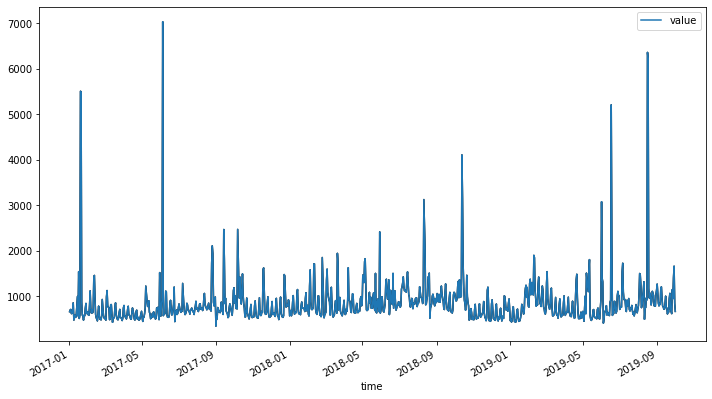

In [5]:
ts = TimeSeriesData(time=ts_sales_h01.time, value=ts_sales_h01.value)
ts.plot(cols=['value'])
plt.show()

## Forecasting with Kats

Kats currently support the following 10 base forecasting models: 

1. Linear  
2. Quadratic   
3. ARIMA   
4. SARIMA   
5. Holt-Winters   
6. Prophet   
7. AR-Net   
8. LSTM   
9. Theta   
10. VAR   

Each models follows the `sklearn` model API pattern:  we create an instance of the model class and then call its `fit` and `predict` methods.  In this section, we provide examples for the Prophet and Theta models.  A more in-depth introduction to forecasting in Kats is provided in [kats_201_forecasting.ipynb](https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_201_forecasting.ipynb).

We will use Prophet as an example on our dataset:

In [6]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="D")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.16154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2196.46   3.28332e-07       71.8305      0.1104           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       2196.46   1.08666e-07       61.6387      0.2871           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [7]:
# the predict method returns a dataframe as follows
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,2019-10-02,1067.669626,446.224583,1692.640485
1,2019-10-03,1074.487602,444.302742,1693.914357
2,2019-10-04,1182.667781,623.028628,1803.220517
3,2019-10-05,1535.805643,950.313985,2103.223669
4,2019-10-06,1526.594316,910.924686,2132.012849


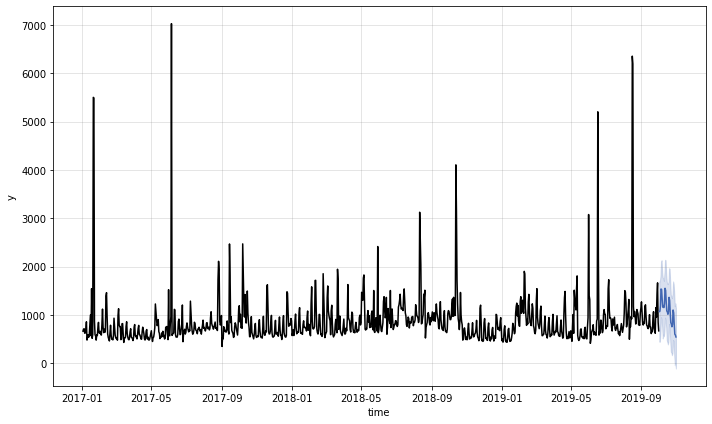

In [8]:
# visualize the results with uncertainty intervals
m.plot()

## Outlier Detection with Kats

Kats provides a set of models and algorithms to detect outliers, change points, and trend changes in time series data.


### Available algorithms

To detect a specific pattern, we provided different algorithms, which is summarized as follows.
- **Outlier Detection**. This usually refers to a abnormal spike in a time series data, which can be detected with `OutlierDetector`
- **Change Point Detection**. This refers to a sudden change that the time series have different statistical properties before and after the change. We provided three major algorithms to detect such patterns:
    - CUSUM Detection
    - Bayesian Online Change Point Detection (BOCPD)
    - Stat Sig Detection
- **Trend Change Detection**. This refers to a slow trend change on the time series data, which can be detected with Mann-Kendall detection algorithm, `MKDetector`

In this tutorial, we will demonstrate the usage of the `OutlierDetector`. For a more in-depth introduction to detection in Kats look at this notebeook: [kats_202_detection.ipynb](https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_202_detection.ipynb).

### An example with outlier detection method

We use the `OutlierDetector` module to detect outliers in time series.  

The outlier detection algorithm works as follows:

- Do a [seasonal decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) of the input time series with additive or multiplicative decomposition as specified (default is additive)
- Generate a residual time series by either removing only trend or both trend and seasonality if the seasonality is strong.
- Detect points in the residual which are outside 3 times the inter quartile range.  This multiplier can be tuned using the `iqr_mult` parameter in `OutlierDetector`.

In [9]:
from kats.detectors.outlier import OutlierDetector

# We use pd.IndexSlice to acces elements in our hierachical data structure
idx = pd.IndexSlice 
    
ts = (df_global_sales_by_hierarchy1
         .to_frame()                    # KATS want's a dataframe, so it gets one
         .loc[idx[:, 'H01', :]]      # We are slicing based on the hierachy
         .reset_index()                 # Our DataFrame has a DateTime index, KATS needs that as a column calld time, so we reindex
         .rename(columns={'date':'time', 'sales':'value'})) # and rename our columns

# Transorm it to a TimeSeriesData Object
ts = TimeSeriesData(ts)
ts_outlierDetection = OutlierDetector(ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

Let's have a look at the outliers that the algorithum found.

In [10]:
outliers = ts_outlierDetection.outliers[0]
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 36


Lets plot the outliers together with our data

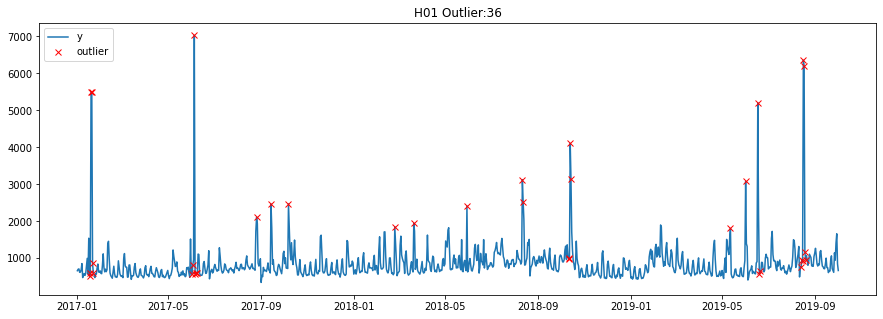

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(ts_sales_h01.set_index('time')['value'], label = 'y' )
ax.plot(ts_sales_h01.set_index('time').loc[outliers, 'value'], linewidth=0, marker='x', color='r', label ='outlier')
ax.legend()

ax.set_title(f'H01 Outlier:{len(outliers)}')
plt.show()

### An example using a prediction model

We use the `Prophet` to build a prediction model for every hierachy1 level timeseries  

The outlier detection algorithm works as follows:

- Train a prediction model for every single time series
- Calculate the insample confidence intervalls for every single time series
- Detect points that exceed the confidence intervalls as outliers for every single time series

In [12]:
# This helper function takes a trained prophet model
# and marks insample outliers, when the exceed the model's
# confidence intervalls 
from sklearn.metrics import mean_squared_error
def plot_prophet_insample_anononalies(model:ProphetModel, title=None):
    # Just do an insample prediction
    future = model.model.make_future_dataframe(periods=0)
    forecast = model.model.predict(future)

    # Joint the history and the prediction DataFrames
    df_results = model.model.history.join(forecast.set_index('ds'), 
                                    on='ds')[['ds', 
                                              'y',
                                              'yhat', 
                                              'yhat_lower',
                                              'yhat_upper']]
    df_results = df_results.set_index('ds')
    
    # Flag values as anonomaly if they exceed the confidence intervalls
    outliers = df_results[(df_results.y > df_results.yhat_upper) |
              (df_results.y < df_results.yhat_lower)]['y']

    # Calc the RMSE to validate the overall prediction performance
    rmse = mean_squared_error(df_results['y'], df_results['yhat'],squared=False)

    # Plot that stuff
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.fill_between(df_results.index, 
                    df_results.yhat_lower, 
                    df_results.yhat_upper, 
                    alpha=0.5,
                    color='grey',
                    label='confidence interval')
                                              
    ax.plot(df_results.yhat, 
            label = '$\hat{y}$')
                                              
    ax.plot(df_results.y, 
            linewidth=0, 
            marker='.',
            color='black',
            label='y')
                                              
    ax.plot(outliers, 
            linewidth=0, 
            marker='x', 
            color ='red',  
            label = 'outlier')
    
    if title:
        ax.set_title(f'{title} Insample RMSE={rmse:.2f}, Outlier:{len(outliers)}')
                                              
    ax.legend(ncol=2)
    plt.show()

In [13]:
from kats.models.prophet import ProphetModel, ProphetParams

# We fit a Prophet model for each hierachy1 level

gs_models_l1 = {}
for hierachy in df_product_hierachy.hierarchy1_id.cat.categories:
    
    # We use pd.IndexSlice to acces elements in our hierachical data structure
    idx = pd.IndexSlice 
    

    # Prepare the data for prophet, don't get confused we do it step by step
    ts = (df_global_sales_by_hierarchy1
         .to_frame()                    # KATS want's a dataframe, so it gets one
         .loc[idx[:, hierachy, :]]      # We are slicing based on the hierachy
         .reset_index()                 # Our DataFrame has a DateTime index, KATS needs that as a column calld time, so we reindex
         .rename(columns={'date':'time', 'sales':'value'})) # and rename our columns
    
    # convert it to KATS TimeSeries object
    ts = TimeSeriesData(ts) 

    # create a model param instance
    params = ProphetParams(interval_width=0.95) # additive mode gives worse results

    # create a prophet model instance
    model = ProphetModel(ts, params)

    # fit model simply by calling m.fit()
    model.fit()
    
    gs_models_l1[hierachy] = model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.52562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2842.24    0.00105077       74.3582           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       2842.73    0.00017143       145.698   1.645e-06       0.001      180  LS failed, Hessian reset 
     185       2843.87   0.000535193       221.047   5.103e-06       0.001      312  LS failed, Hessian reset 
     199       2843.94   8.73978e-05        76.871      0.8814      0.8814      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       2844.15   3.29504e-05       77.5331   3.795e-07       0.001      490  LS failed, Hessian reset 
     299       2844.15   1.85429e-05       89.8506      0.8864      0.8864      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.02603
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2403.04   0.000290442       60.3227      0.2931           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2403.54   2.79863e-05       75.6722       3.797           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       2403.69   0.000105875       61.6496    1.15e-06       0.001      385  LS failed, Hessian reset 
     299       2403.69   9.21025e-07       66.6384           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384       2403.69   1.50974e-07       50.9777      0.3677           1      550   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.6886
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2516.29    6.9821e-05       148.913     0.06673    0.006673      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       2518.88   0.000533992       176.001   6.712e-06       0.001      297  LS failed, Hessian reset 
     199       2518.95   0.000929636       149.037           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       2520.07   0.000309029       152.471   1.328e-06       0.001      405  LS failed, Hessian reset 
     299       2520.65   2.84185e-06       78.3506      0.2988      0.9095      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       2520.69   0.000151727       85.5042   1.864e-06       0.001      538  LS failed, Hessian rese

Lets see what we got with this approach:


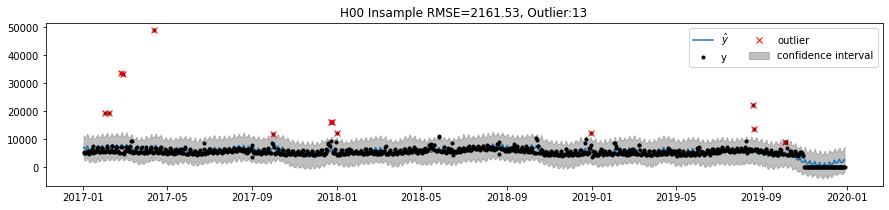

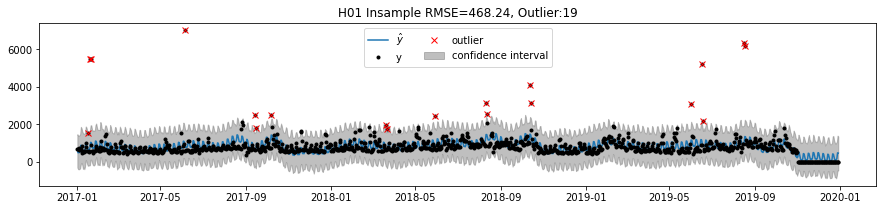

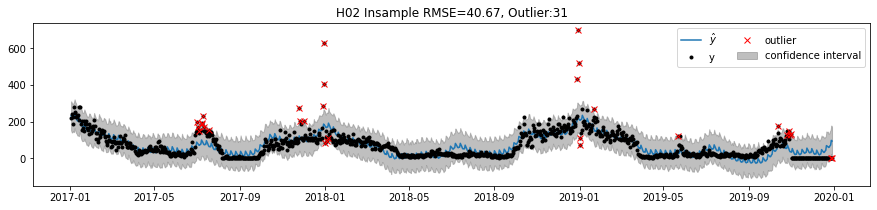

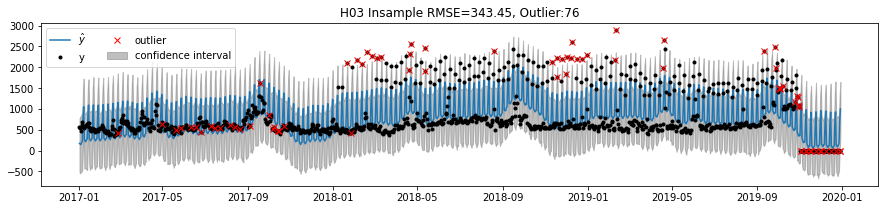

In [14]:
for key in gs_models_l1:
    plot_prophet_insample_anononalies(gs_models_l1[key], key)

## Trends and seasonalities
Most of the Kats models, do a  [seasonal decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) of the input time series with additive or multiplicative decomposition as specified (default is additive).
We can also make use of that to explore trends and seasonalities in our time series:

We see:

**Trend**
- Our time series has an increasing trend since `2017` until ~ `05-2018`. 
- After that it keeps the level until `04-2019` and is 
- decreasing after that until the end. 

**Seasonality weekly**
- Saturdays and Sundays are the strongest days
- Tuesday until Friday there is a lower acitivity

**Seasonality yearly**
- In a yearly cycle we have peaks around August and Oktober
- November until January have a low volume

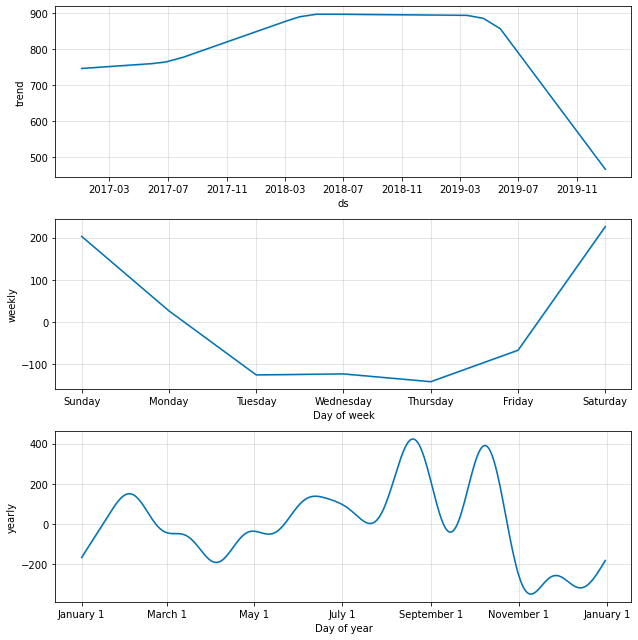

In [15]:
# Lets take our forecast from H01 as an example

model = gs_models_l1['H01']

future = model.model.make_future_dataframe(periods=0)
forecast = model.model.predict(future)

# Plot the single components of our prophet model
model.model.plot_components(forecast)
plt.show()

## Detecting time windows with increasing/decreasing sales amounts
for a more detailed explanation have a look into the KATS jupyter example notebook on detection [kats_202_detection.ipynb](https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_202_detection.ipynb)

In [16]:
# Prepare the data for prophet, don't get confused we do it step by step
ts = (df_global_sales_by_hierarchy1
     .to_frame()                    # KATS want's a dataframe, so it gets one
     .loc[idx[:, 'H01', :]]      # We are slicing based on the hierachy
     .reset_index()                 # Our DataFrame has a DateTime index, KATS needs that as a column calld time, so we reindex
     .rename(columns={'date':'time', 'sales':'value'})) # and rename our columns
ts = TimeSeriesData(ts)

`MKDetector` is the trend detection algorithm that we include in Kats, which is based on the non-parametric Mann-Kendall (MK) Test. What the`MKDetector essentially does is apply a MK to a window of fied size (specified by the `window_size argument` in the`detector` method) and return the end point of each window for which this test is statistically significant. Trend windows are detected based on the monotonicity of the increases or decreases in the time series in the window, not the magnitude of the change in the value of the time series over the window.

For this example we want to detect time windows, where a decreasing trend persisted for minimum 21 days

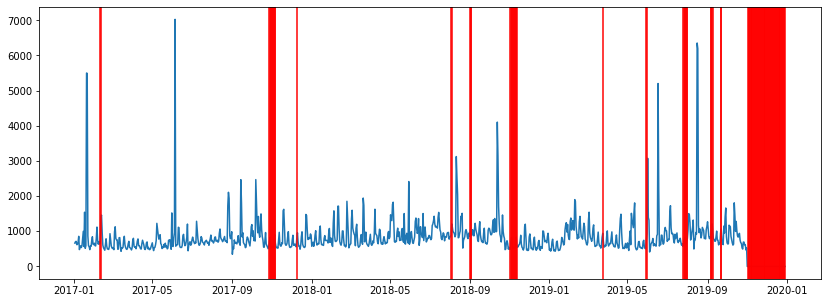

In [17]:
from kats.detectors.trend_mk import MKDetector

detector = MKDetector(data=ts, threshold=.8)
# run detector
detected_time_points = detector.detector(direction='down', window_size=21)
# plot the results
detector.plot(detected_time_points)
plt.show()

The return type of the detector method is `List[Tuple[TimeSeriesChangePoint, MKMetadata]`. Each `TimeSeriesChangePoin` returned is the end of an increasing or decreasing trend window of duration `window_size`. In our example, we are looking for decreasing trend windows of length 21.

In [18]:
cp, meta = detected_time_points[0]
cp

TimeSeriesChangePoint(start_time: 2017-02-10 00:00:00, end_time: 2017-02-10 00:00:00, confidence: 0.9999998739248479)

# Generating insights

## Who is resposible for the outliers in H01 at `2019-08-16` and `2019-08-17` ? 

In [19]:
# Let's get all sales for hierachy1_id and look at the sales in the second level.
df_global_sales_h01 = df_sales[df_sales.hierarchy1_id=='H01'][['date', 'sales', 'store_id','hierarchy2_id']]
df_global_sales_h01_by_h2 = df_global_sales_h01.groupby(['date', 'hierarchy2_id'])['sales'].sum()
df_global_sales_h01.head()

,date,sales,store_id,hierarchy2_id
0,2017-01-02,0.0,S0002,H0105
1,2017-01-02,1.0,S0012,H0105
2,2017-01-02,2.0,S0013,H0105
3,2017-01-02,0.0,S0023,H0105
4,2017-01-02,0.0,S0025,H0105


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.02301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2663.77     0.0029299       74.9154       1.133      0.9543      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       2665.05   0.000134549       92.5592   1.364e-06       0.001      322  LS failed, Hessian reset 
     199       2665.48   0.000367165       70.9194      0.2294           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2665.72   4.83985e-06       74.3611      0.3035           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       2665.72   6.07944e-07       58.7565      0.5241           1      510   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.05294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3113.32   0.000312485       105.236     0.09342     0.09342      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        3113.4   9.35717e-05       118.481   7.734e-07       0.001      237  LS failed, Hessian reset 
     187       3113.43   3.57641e-05       62.3471   5.705e-07       0.001      337  LS failed, Hessian reset 
     199       3113.43   1.43319e-06       51.7058      0.1993           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3113.43   8.21517e-08        65.042     0.07368           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.02592
    Iter      log prob        ||dx||      ||grad||   

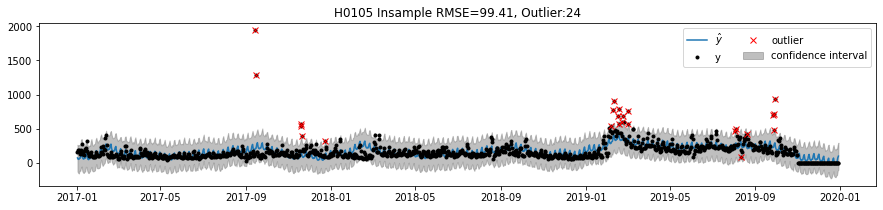

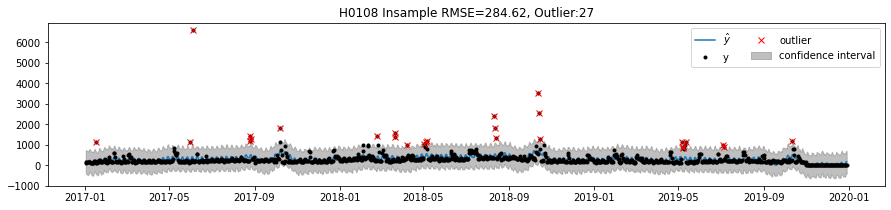

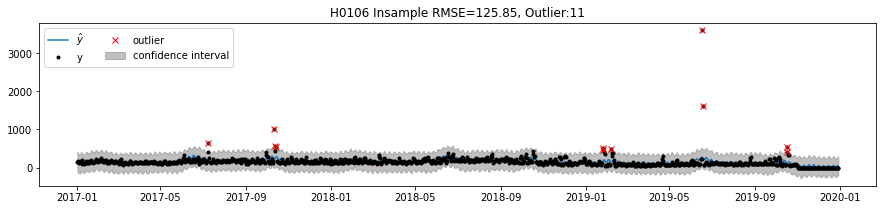

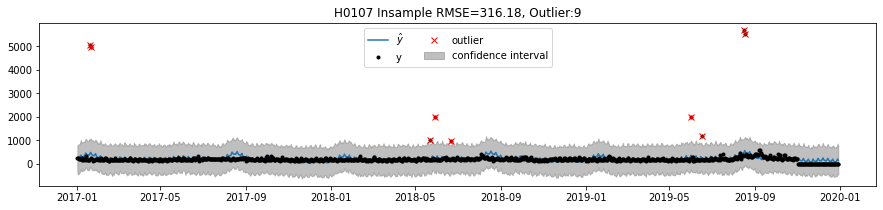

In [20]:
# Fit again models for every hierachy on level 2
gs_models_l2 = {}
for hierachy in df_global_sales_h01.hierarchy2_id.unique():
    idx = pd.IndexSlice

    # Prepare the data for prophet, don't get confused we do it step by step
    ts = (df_global_sales_h01_by_h2
         .to_frame()                    # KATS want's a dataframe, so it gets one
         .loc[idx[:, hierachy, :]]      # We are slicing based on the hierachy
         .reset_index()                 # Our DataFrame has a DateTime index, KATS needs that as a column calld time, so we reindex
         .rename(columns={'date':'time', 'sales':'value'})) # and rename our columns
    
    # convert it to KATS TimeSeries object
    ts = TimeSeriesData(ts) 

    # create a model param instance
    params = ProphetParams(interval_width=0.95) # additive mode gives worse results

    # create a prophet model instance
    model = ProphetModel(ts, params)

    # fit model simply by calling m.fit()
    model.fit()
    
    gs_models_l2[hierachy] = model
    
    
# Let's see what we've got

for key in gs_models_l2:
    plot_prophet_insample_anononalies(gs_models_l2[key], key)

### Possible Insight: 
Anomaly! The sales at `2019-08-17`, `2019-08-17` in Category H01 where by #% higher than expected. This was due to an increase in sales of Type H0107 by #%


## What about trends?

# Further Questions (just some brainstorming ideas):
- Is this a global trend, or does it only apply to a specific store/city?
- How does this affect the revenue and the material stock?
- Are there trend changes in the dataset?
- Are the sales affected by any promo codes?
- Are there repeating sub-series?
- Can you idetify clusters in anomalies across different product hierachies/stores
- Show us, what you find in the dataset and tell us a story